In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [8]:
# data:  https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
# refs:
# https://www.kaggle.com/code/jesucristo/fraud-complete-eda#Data
# https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook#Equally-Distributing-and-Correlating:
# https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600
# https://www.kaggle.com/code/cdeotte/rapids-feature-engineering-fraud-0-96

dtypes = {"Time": np.uint32,
          "Class": bool}

data = pd.read_csv("../data/creditcard.csv", dtype=dtypes)

In [9]:
data["isFraud"] = data["Class"]
data.drop("Class", axis=1, inplace=True)
print(data.info(memory_usage="deep"))

display(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Time     284807 non-null  uint32 
 1   V1       284807 non-null  float64
 2   V2       284807 non-null  float64
 3   V3       284807 non-null  float64
 4   V4       284807 non-null  float64
 5   V5       284807 non-null  float64
 6   V6       284807 non-null  float64
 7   V7       284807 non-null  float64
 8   V8       284807 non-null  float64
 9   V9       284807 non-null  float64
 10  V10      284807 non-null  float64
 11  V11      284807 non-null  float64
 12  V12      284807 non-null  float64
 13  V13      284807 non-null  float64
 14  V14      284807 non-null  float64
 15  V15      284807 non-null  float64
 16  V16      284807 non-null  float64
 17  V17      284807 non-null  float64
 18  V18      284807 non-null  float64
 19  V19      284807 non-null  float64
 20  V20      284807 non-null  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,isFraud
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [10]:
dulicates = len(data[data.duplicated()])
print(f"{dulicates} duplicates were removed")
data = data.drop_duplicates(keep="first")

1081 duplicates were removed


In [11]:
print("{}% of data missing".format(data.isna().sum().sum() / np.prod(data.shape) * 100))

0.0% of data missing


In [12]:
fraud_percentage = data["isFraud"].value_counts(normalize=True) * 100
print("Not Frauds: {:.2f}% of the dataset".format(fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the dataset".format(fraud_percentage.iloc[1]))

Not Frauds: 99.83% of the dataset
Frauds: 0.17% of the dataset


In [14]:
print(data[["Time", "Amount"]].describe())

                Time         Amount
count  283726.000000  283726.000000
mean    94811.077600      88.472687
std     47481.047891     250.399437
min         0.000000       0.000000
25%     54204.750000       5.600000
50%     84692.500000      22.000000
75%    139298.000000      77.510000
max    172792.000000   25691.160000


In [ ]:
data["Time"].max() / (60 ** 2)

np.float64(47.99777777777778)

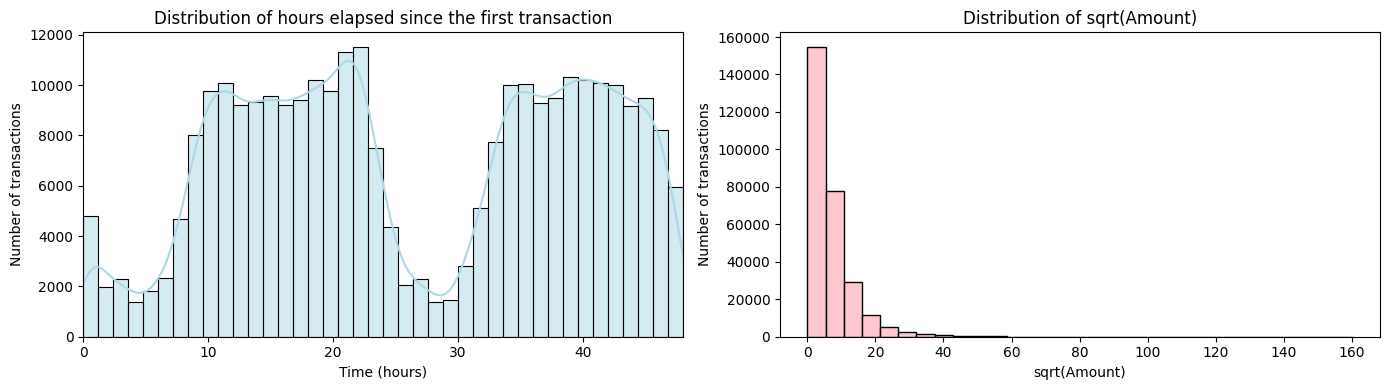

10196

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

hours_passed = data["Time"].values / (60 ** 2)
amount_transformed = np.sqrt(data["Amount"].values)

sns.histplot(hours_passed, ax=ax[0], kde=True, color="lightblue", bins=40)
ax[0].set_title("Distribution of hours elapsed since the first transaction")
ax[0].set_xlabel("Time (hours)")
ax[0].set_xlim([min(hours_passed), max(hours_passed)])
ax[0].set_ylabel("Number of transactions")


sns.histplot(amount_transformed, kde=False, ax=ax[1], color="lightpink", bins=30)
ax[1].set_title("Distribution of sqrt(Amount)")
ax[1].set_xlabel("sqrt(Amount)")
ax[1].set_ylabel("Number of transactions")

plt.tight_layout()
plt.show()

del hours_passed, amount_transformed
gc.collect()


In [ ]:
# Value in [0, 1) indicating where within a 24-hour cycle the event occurs.
data["Time_day"] = data["Time"] / (60 * 60 * 24) % 1

# Cyclical encoding
data["time_sin"] =  np.sin(2 * np.pi * data["Time_day"])
data["time_cos"] =  np.cos(2 * np.pi * data["Time_day"])

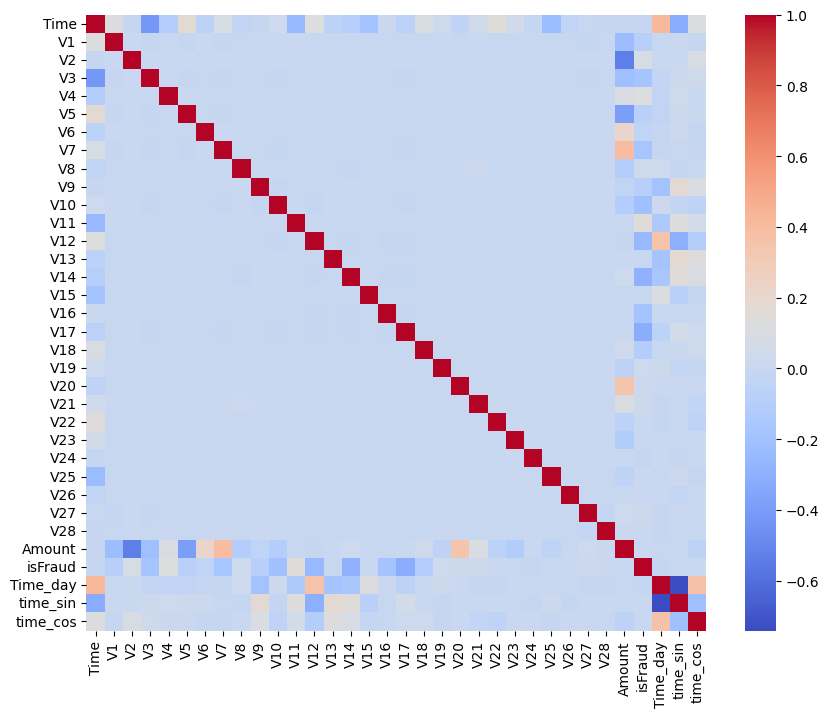

Series([], dtype: int64)


In [69]:
plt.figure(figsize=(10, 8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm')
plt.show()

high_corr = (corr.abs() > 0.90).sum()
print(high_corr[high_corr > 1])

In [ ]:
# v_features = [f"V{i}" for i in range(1, 29)]
# for v in v_features:
#     data[f"V15*{v}"] = data["V15"] * data[v]

# data.columns


In [70]:
from sklearn.utils import resample

fraud = data[data['isFraud'] == 1]
non_fraud = data[data['isFraud'] == 0]

non_fraud_downsampled = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud),
    random_state=11
)

data_downsampled = pd.concat([fraud, non_fraud_downsampled])

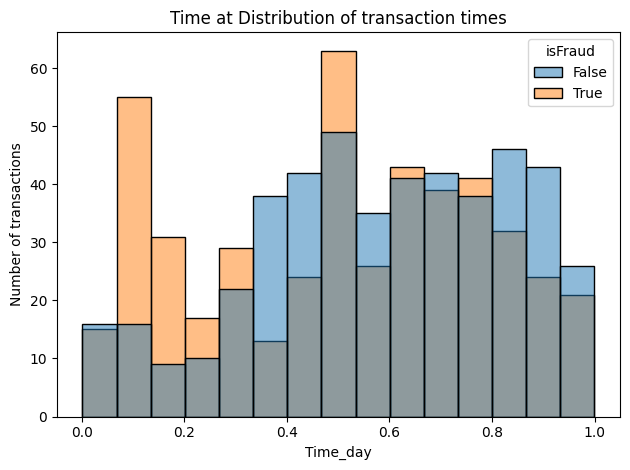

In [94]:
sns.histplot(data=data_downsampled, x="Time_day", hue="isFraud", bins=15)
plt.title("Time at Distribution of transaction times")
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()

/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


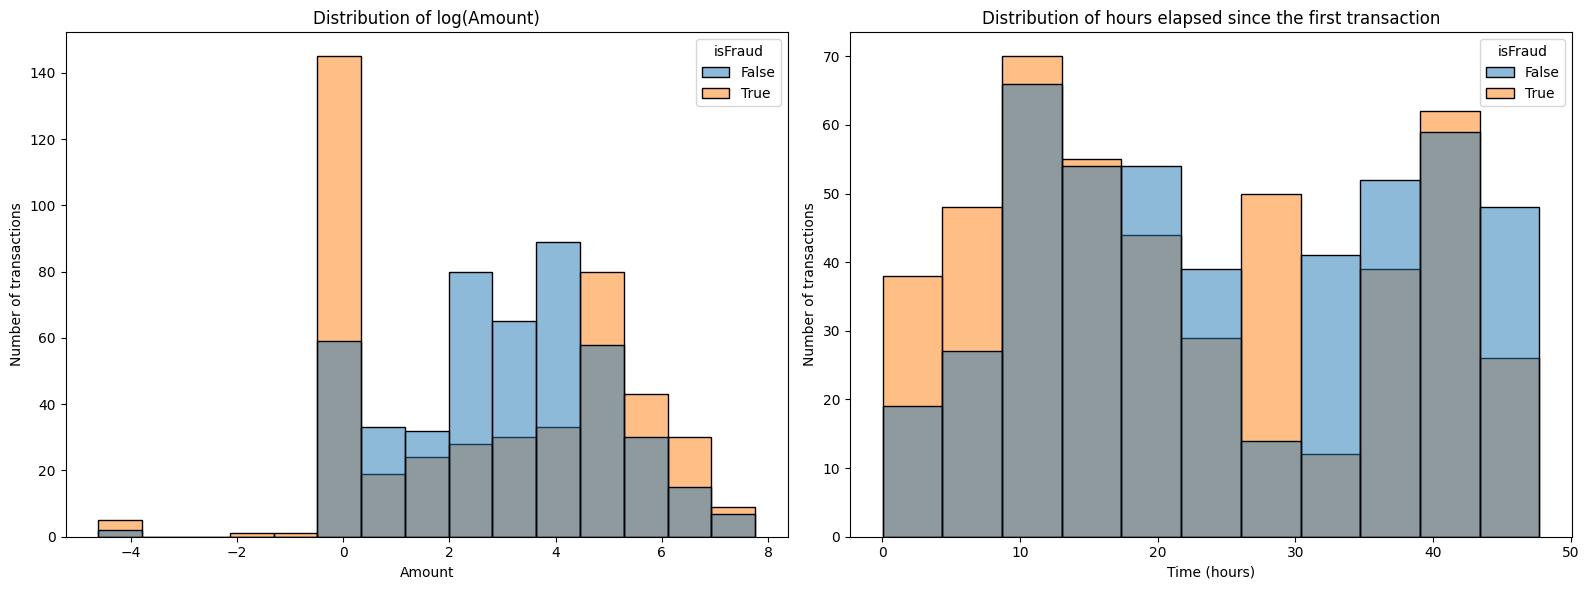

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=data_downsampled, x=np.log(data_downsampled["Amount"]), ax=axes[0], color="red", hue="isFraud")
axes[0].set_title("Distribution of log(Amount)")
axes[0].set_ylabel("Number of transactions")# plt.show()

sns.histplot(data=data_downsampled, x=data_downsampled["Time"] / (60 ** 2), ax=axes[1],  color="red", hue="isFraud")
axes[1].set_title("Distribution of hours elapsed since the first transaction")
axes[1].set_ylabel("Number of transactions")
axes[1].set_xlabel("Time (hours)")

plt.tight_layout()
plt.show()

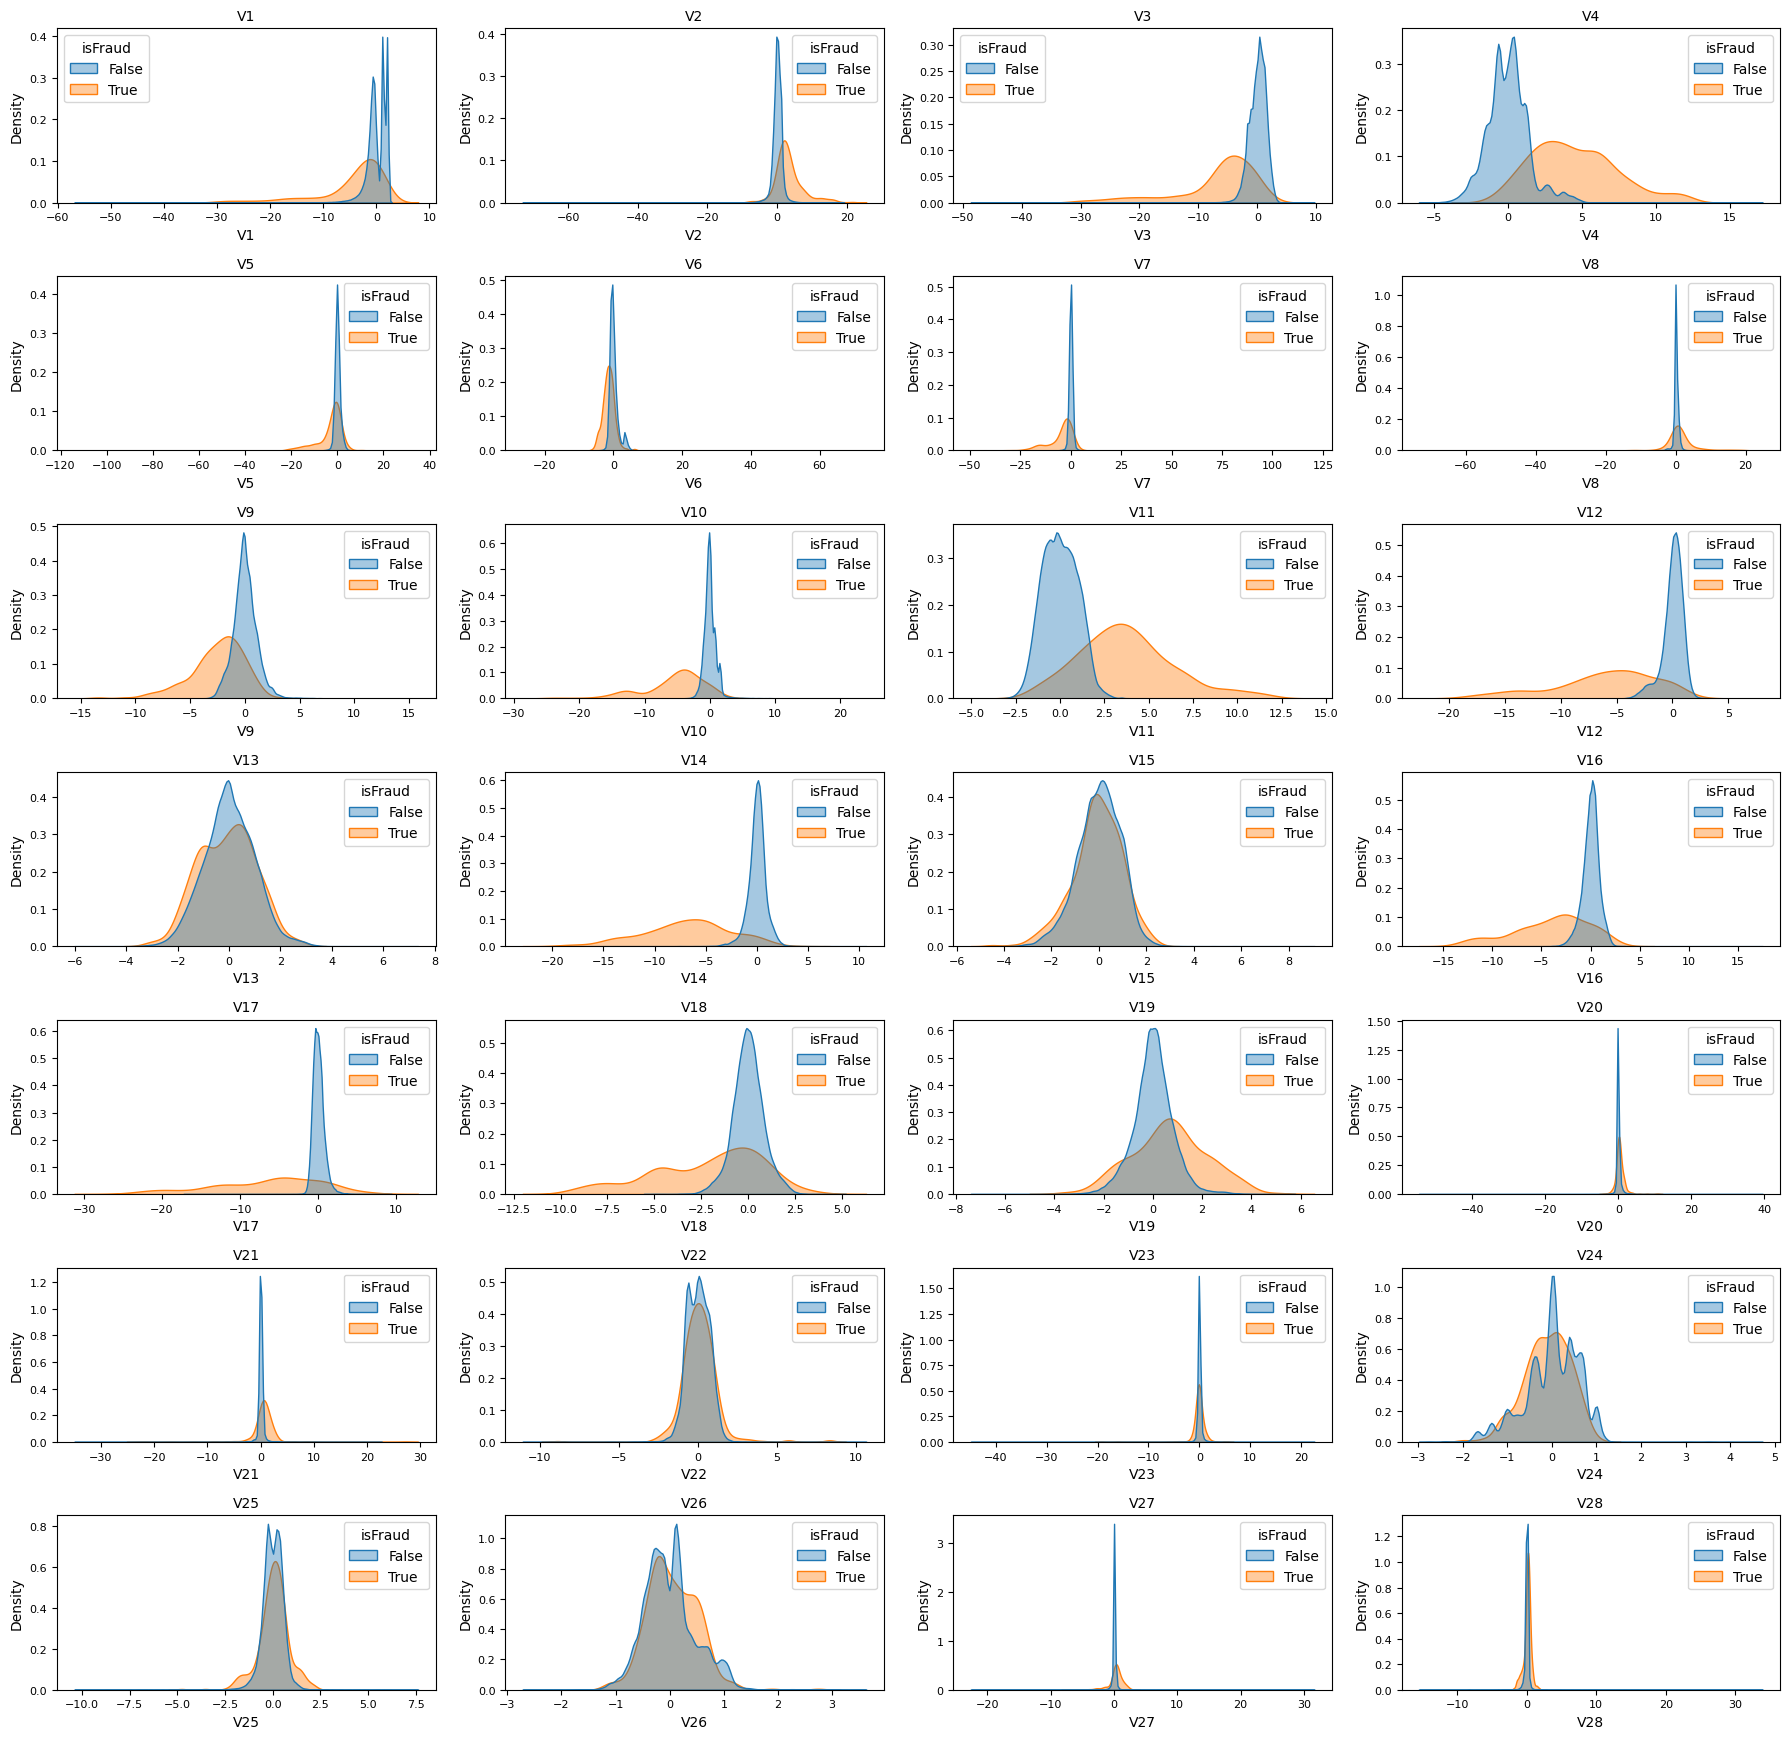

In [95]:
v_features = [f"V{i}" for i in range(1, 29)]
n_cols = 4
n_rows = (len(v_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(v_features):
    ax = axes[i]
    sns.kdeplot(
        data=data,
        x=col,
        hue='isFraud',
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=ax,
        linewidth=1
    )
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)


plt.tight_layout()
plt.show()


In [ ]:
%%time
from sklearn.model_selection import train_test_split, TimeSeriesSplit

X = data.drop(["isFraud"], axis=1)
y = data["isFraud"]

train_size = int(0.8 * len(data))

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

train_fraud_percentage = y_train.value_counts(normalize=True) * 100
test_fraud_percentage = y_test.value_counts(normalize=True) * 100

print("Not Frauds: {:.2f}% of the train set".format(train_fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the train set".format(train_fraud_percentage.iloc[1]),'\n')

print("Not Frauds: {:.2f}% of the test set".format(test_fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the test set".format(test_fraud_percentage.iloc[1]), '\n')


tscv = TimeSeriesSplit(n_splits=4)

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    print(f"\nFold {fold}")
    print(f"Train indices: {train_idx[0]} to {train_idx[-1]} (size: {len(train_idx)})")
    print(f"Val indices: {val_idx[0]} to {val_idx[-1]} (size: {len(val_idx)})")
    
    # Get the train and validation data for this fold
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]

del train_fraud_percentage, test_fraud_percentage
h = gc.collect()

Not Frauds: 99.82% of the train set
Frauds: 0.18% of the train set 

Not Frauds: 99.87% of the test set
Frauds: 0.13% of the test set 


Fold 1
Train indices: 0 to 45395 (size: 45396)
Val indices: 45396 to 90791 (size: 45396)

Fold 2
Train indices: 0 to 90791 (size: 90792)
Val indices: 90792 to 136187 (size: 45396)

Fold 3
Train indices: 0 to 136187 (size: 136188)
Val indices: 136188 to 181583 (size: 45396)

Fold 4
Train indices: 0 to 181583 (size: 181584)
Val indices: 181584 to 226979 (size: 45396)
CPU times: user 237 ms, sys: 156 ms, total: 394 ms
Wall time: 475 ms


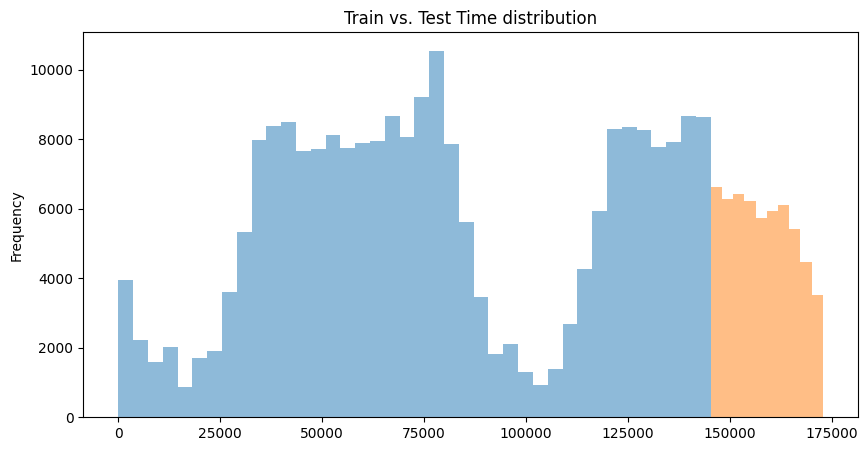

In [105]:
X_train["Time"].plot(kind="hist",
                     figsize=(10, 5),
                     label="train",
                     bins=40,
                     alpha=0.5,
                     title="Train vs. Test Time distribution")
X_test["Time"].plot(kind="hist",
                     figsize=(10, 5),
                     label="test",
                     alpha=0.5)

plt.show()

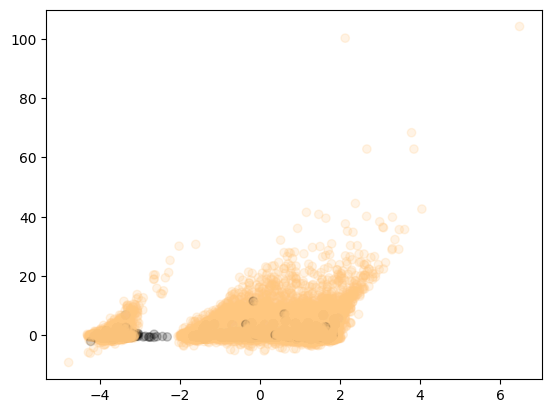

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=2)
PCA_train_x = pca.fit_transform(X_train_scaled)

plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r", alpha=0.2)
plt.show()


In [110]:
%%time
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score, accuracy_score
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier


other_features = X.drop(["Time", "Amount"], axis=1).columns.to_list()

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=11,
    n_jobs=-1,
)

# model = BalancedRandomForestClassifier(
#     random_state=11,
#     n_jobs=-1,
# )

preprocessor = ColumnTransformer([
    ("time_preprocess", RobustScaler(), ["Time"]),
    ("amount_preprocess", StandardScaler(), ["Amount"]),
    ('pass', 'passthrough', other_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=11)),
    ("clf", model)
])

param_dist = {
    'clf__n_estimators': [100, 300, 500, 800, 1000],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7, 9, 11],
    'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.3, 0.5, 1],
    'clf__min_child_weight': [1, 3, 5, 7, 10],
    'clf__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'clf__reg_lambda': [0.1, 1, 5, 10, 20]
}

# param_dist = {
#     'clf__n_estimators': [100, 300, 500, 800, 1000],
#     'clf__max_depth': [3, 5, 7, 9, 11, None],  # None allows nodes to expand until all leaves are pure
#     'clf__min_samples_split': [2, 5, 10, 20],
#     'clf__min_samples_leaf': [1, 2, 4, 8],
#     'clf__max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
#     'clf__bootstrap': [True, False],
#     'clf__class_weight': ['balanced', 'balanced_subsample', None],
#     'clf__max_samples': [0.6, 0.7, 0.8, 0.9, 1.0]  # Proportion of samples to draw for each tree
# }

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, pos_label=1)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring=scoring,
    refit='recall',
    verbose=2,
    n_jobs=-1,
    random_state=11
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV Recall:", search.cv_results_['mean_test_recall'][search.best_index_])
print("Best CV Accuracy:", search.cv_results_['mean_test_accuracy'][search.best_index_])

Fitting 4 folds for each of 20 candidates, totalling 80 fits


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

[CV] END clf__colsample_bytree=0.8, clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.6; total time=   5.0s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

[CV] END clf__colsample_bytree=0.7, clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.9; total time=   8.4s
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.6; total time=   8.7s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.8; total time=   5.0s
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.6; total time=  12.8s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  15.7s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.6; total time=  16.2s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.8; total time=   8.4s
[CV] END clf__colsample_bytree=0.9, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=9, clf__min_child_weight=3, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=0.1, clf__subsample=0.9; total time=   6.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.8; total time=  11.7s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  23.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=0.9; total time=   5.9s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.8; total time=  15.3s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  30.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=9, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=   5.0s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=0.9; total time=  11.5s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.9, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=9, clf__min_child_weight=3, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  17.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.9, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=100, clf__reg_alpha=0, clf__reg_lambda=10, clf__subsample=0.8; total time=   3.3s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=0.9; total time=  16.2s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=9, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=  10.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.9, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=100, clf__reg_alpha=0, clf__reg_lambda=10, clf__subsample=0.8; total time=   6.0s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=0.9; total time=  18.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.9, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=9, clf__min_child_weight=3, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  28.5s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.9, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=100, clf__reg_alpha=0, clf__reg_lambda=10, clf__subsample=0.8; total time=   7.7s
[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=9, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=  16.8s
[CV] END clf__colsample_bytree=0.9, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=9, clf__min_child_weight=3, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=0.1, clf__subsample=0.9; total time=  31.8s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.01, clf__max_depth=9, clf__min_child_weight=10, clf__n_estimators=100, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=1.0; total time=   4.2s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=9, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=  20.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=10, clf__subsample=0.8; total time=  11.1s
[CV] END clf__colsample_bytree=0.9, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=100, clf__reg_alpha=0, clf__reg_lambda=10, clf__subsample=0.8; total time=  14.0s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.01, clf__max_depth=9, clf__min_child_weight=10, clf__n_estimators=100, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=1.0; total time=   8.0s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=11, clf__min_child_weight=3, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=5, clf__subsample=0.7; total time=   4.8s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.01, clf__max_depth=9, clf__min_child_weight=10, clf__n_estimators=100, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=1.0; total time=  12.0s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=11, clf__min_child_weight=3, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=5, clf__subsample=0.7; total time=  12.1s
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=10, clf__subsample=0.8; total time=  23.2s
[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.01, clf__max_depth=9, clf__min_child_weight=10, clf__n_estimators=100, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=1.0; total time=  15.5s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=500, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.9; total time=   6.5s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=11, clf__min_child_weight=3, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=5, clf__subsample=0.7; total time=  17.4s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=   4.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=500, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.9; total time=  13.4s
[CV] END clf__colsample_bytree=0.7, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=11, clf__min_child_weight=3, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=5, clf__subsample=0.7; total time=  22.0s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=10, clf__subsample=0.8; total time=  40.2s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  10.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.9; total time=   7.9s
[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=500, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.9; total time=  24.4s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  16.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=   2.8s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.7, clf__gamma=0, clf__learning_rate=0.2, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=500, clf__reg_alpha=1, clf__reg_lambda=5, clf__subsample=0.9; total time=  29.4s
[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=   5.7s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=10, clf__subsample=0.8; total time=  51.3s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   4.1s
[CV] END clf__colsample_bytree=0.6, clf__gamma=1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.9; total time=  17.4s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=   8.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=500, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  24.3s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   9.0s
[CV] END clf__colsample_bytree=0.8, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=   4.9s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.7; total time=  14.2s
[CV] END clf__colsample_bytree=0.6, clf__gamma=1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.9; total time=  27.2s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  10.9s
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.6; total time=  16.2s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  16.3s
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=0.1, clf__max_depth=9, clf__min_child_weight=7, clf__n_estimators=300, clf__reg_alpha=10, clf__reg_lambda=0.1, clf__subsample=0.6; total time=  22.7s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.6, clf__gamma=1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=1000, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=0.9; total time=  36.2s
[CV] END clf__colsample_bytree=0.6, clf__gamma=1, clf__learning_rate=0.01, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=800, clf__reg_alpha=0, clf__reg_lambda=5, clf__subsample=0.8; total time=  14.2s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.01, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=10, clf__reg_lambda=20, clf__subsample=1.0; total time=   3.1s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END clf__colsample_bytree=0.8, clf__gamma=1, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=300, clf__reg_alpha=0.01, clf__reg_lambda=1, clf__subsample=1.0; total time=  20.7s
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.5, clf__learning_rate=0.01, clf__max_depth=11, clf__min_child_weight=1, clf__n_estimators=100, clf__reg_alpha=10, clf__reg_lambda=20, clf__subsample=1.0; total time=   8.5s


/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/david/miniconda3/envs/ml/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

[CV] END clf__colsample_bytree=1.0, clf__gamma=0.3, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=1000, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=  10.4s
CPU times: user 1.34 s, sys: 1.52 s, total: 2.85 s
Wall time: 2min 31s


KeyboardInterrupt: 

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report

best_model = search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold (by F1): {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}")

y_pred_opt = (y_pred_prob >= best_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, digits=3))

Best threshold (by F1): 0.976
Precision: 0.962, Recall: 0.689
[[56670     2]
 [   23    51]]
              precision    recall  f1-score   support

       False      1.000     1.000     1.000     56672
        True      0.962     0.689     0.803        74

    accuracy                          1.000     56746
   macro avg      0.981     0.845     0.901     56746
weighted avg      1.000     1.000     1.000     56746



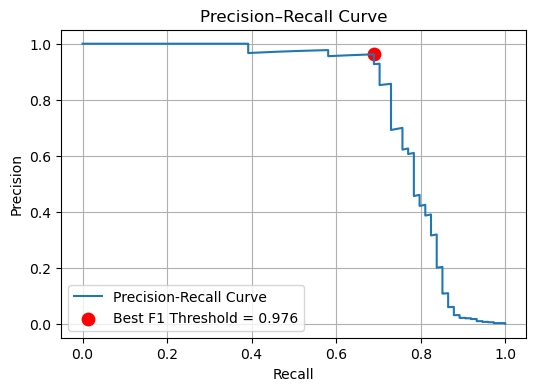

In [50]:
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=80,
            label=f'Best F1 Threshold = {best_threshold:.3f}')
plt.title('Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
target_recall = 0.7
idx = np.argmin(np.abs(recalls - target_recall))
target_threshold = thresholds[idx]
target_precision = precisions[idx]

print(f"Threshold for recall ~{target_recall}:", target_threshold)
print("Precision at this threshold:", round(target_precision, 2))
print("Actual recall at this threshold:", round(recalls[idx], 2))

Threshold for recall ~0.7: 0.956054
Precision at this threshold: 0.85
Actual recall at this threshold: 0.7


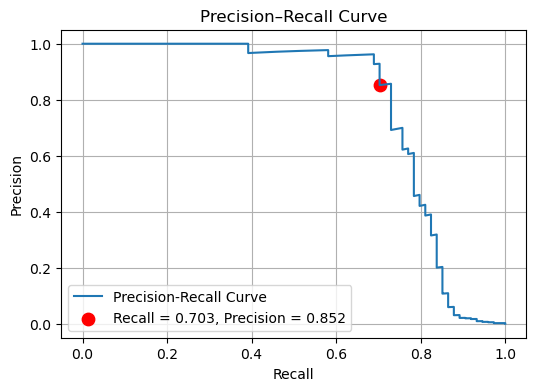

In [69]:
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.scatter(recalls[idx], precisions[idx], color='red', s=80,
            label=f'Recall = {recalls[idx]:.3f}, Precision = {precisions[idx]:.3f}')
plt.title('Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

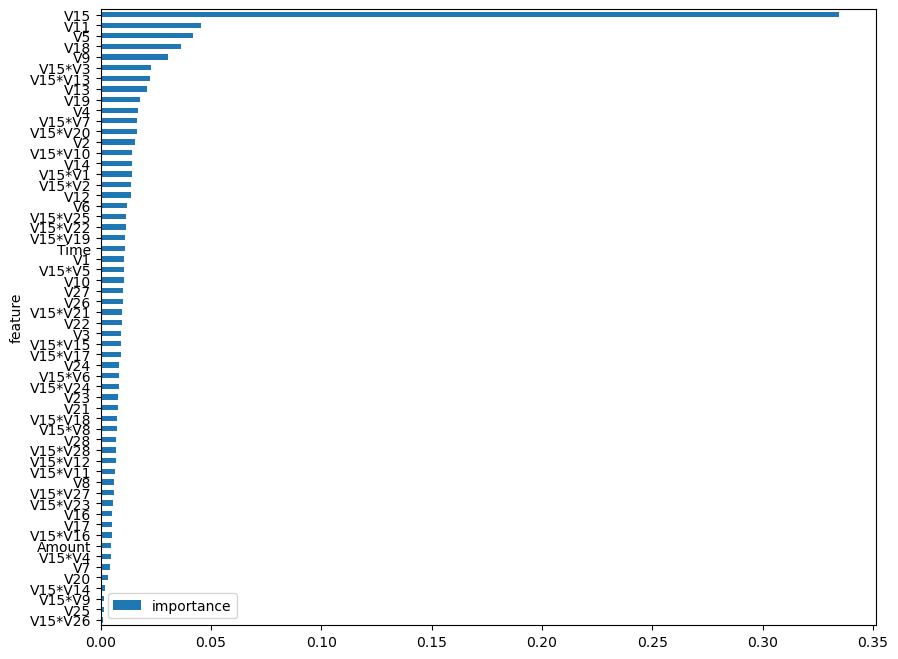

In [59]:
xgb_model = search.best_estimator_.named_steps['clf']

features = X_train.columns
importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi_df.plot(kind="barh", x="feature", y="importance", figsize=(10,8))
plt.gca().invert_yaxis()
plt.show()